## Mounting files from google drive
##### You can use shortcut to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## going desired directory
##### change it according to yours

In [2]:
%cd drive/MyDrive/CI_phase3
%ls

/content/drive/MyDrive/CI_phase3
load_features.py  phase_3_code.ipynb  test_data.npz      train_data.npz
model.png         phase_3.ipynb       test_data_SYN.npz  train_data_SYN.npz


## Imports

In [3]:
import numpy as np
from typing import Tuple
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn import svm

import time

## Load function

In [4]:
# Load the data and label
def load_data(filename: str) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(f'{filename}')
    return data['data'], data['labels']

# Split the data and labels into training and testing sets

train_data, train_labels = load_data('train_data_SYN.npz')

print(train_data.shape)
print(np.unique(train_labels, return_counts=True))

test_data, test_labels = load_data('test_data_SYN.npz')
print(test_data.shape)
print(np.unique(test_labels, return_counts=True))

(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([563, 633, 529, 482, 486, 456, 504, 486, 442, 419]))
(5000, 1024)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([483, 539, 539, 484, 490, 526, 483, 506, 471, 479]))


In [5]:
train_labels

array([8, 2, 5, ..., 9, 2, 0])

## Model function
##### It is out model that its parameters are according to the inputs:
- train_data -----------      training data as a numpy array
- train_labels ---------      labales of training data as a numpy array
- test_data ------------      test data as a numpy array
- test_labels ----------      labales of test data as a numpy array
- reg_l1_param ------         L1 regularisation parameter
- hidden_size ---------       size of hidden layer in the model
- top_featur_count -          number of features that have to be selected in  each training
- epochs ---------------- number of epochs in each traing

In [8]:
def model_func(train_data, train_labels, test_data, test_labels, reg_l1_param=10e-2, hidden_size=128, top_featur_count = 10, epochs=10):
  report = []
  input_tensor = tf.keras.Input(shape=(train_data.shape[1],))

  hidden_layer_1 = tf.keras.layers.Dense(units=hidden_size, activation=tf.nn.relu, activity_regularizer=tf.keras.regularizers.l1(reg_l1_param))(input_tensor)

  output_layer = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)(hidden_layer_1)
  model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(train_data, train_labels, epochs=epochs, batch_size=32, validation_data=(test_data, test_labels), verbose=1)

  test_loss, test_acc = model.evaluate(test_data, test_labels)
  print('feature_no:', train_data.shape[1], ' reg_l1_param:', reg_l1_param, ' hidden_size:', hidden_size, ' Test accuracy:', test_acc)
  print("---------------------------------------------------------------------")

  weights = model.layers[1].get_weights()[0]
  # plt.plot(weights[0])
  # plt.show()

  # weights  = np.clip(weights, a_min=0, a_max=None)
  # plt.plot(weights[0])
  # plt.show()

  # Compute the L1-norm of the weights along the feature axis
  l1_norms = np.mean(np.abs(weights), axis=1)
  # l1_norms = np.sum((np.clip(weights, a_min=0, a_max=None)), axis=1)

  # Sort
  sorted_indices = np.argsort(l1_norms, kind='quicksort')[::-1]
  top_features = sorted_indices[:top_featur_count]

  # print('Top 10 features idx:', top_features)
  # print('Top 10 features :',l1_norms[sorted_indices[:10]])
  report.append(top_features)
  report.append(l1_norms[sorted_indices[:top_featur_count]])
  report.append(l1_norms)
  report.append(weights)
  report.append(history.history['loss'])
  report.append(history.history['val_loss'])
  report.append(history.history['accuracy'])
  report.append(history.history['val_accuracy'])

  # np.savez(f'res-domain{domain_no}-reg_l1_param{reg_l1_param}', sorted_indices, l1_norms)

  return report

## finding best hidden_size and reg_l1_param


In [ ]:
# reg_l1_param_list = [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6]
# hidden_size_list = [10, 32, 128, 200, 250, 300]
# reports = []
# for i in range(len(reg_l1_param_list)):
#   reg_l1_param = reg_l1_param_list[i]
#   print("\nreg_l1_param:", reg_l1_param)
#   for j in range(len(hidden_size_list)):
#     hidden_size = hidden_size_list[j]
#     print("hidden_size:", hidden_size)
#     reports.append(model_func(train_data, train_labels, test_data, test_labels, reg_l1_param, hidden_size))
#     # plt.plot(l1_norms)

## Finding best  

In [15]:
penalty = 0.00075
reg_l1_param = 10e-5
hidden_size = 200
epochs = 10

# top_featur_count_list = [81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 90]
top_featur_count_list = [67]

iterartion_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
iterartion_list = [1, 2]
print("reg_l1_param: ", reg_l1_param)
print("hidden_size: ", hidden_size)
for j in range(len(top_featur_count_list)):

  # iterartion_list = [12]
  report_itr_list = []
  top_featur_count = top_featur_count_list[j]

  # print("top_featur_count: ", top_featur_count)
  # print("iterartion_list: ", iterartion_list)
  # print("epochs: ", epochs)

  start = time.time()
  clf = svm.SVC(kernel='rbf') # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
  # clf.fit(train_data, train_labels)
  # y_pred = clf.predict(test_data)
  # accuracy = accuracy_score(test_labels, y_pred)
  # print("rbf-Accuracy:", accuracy)
  # score = accuracy - (train_data.shape[1] * penalty)
  # print("score: ", score)
  end = time.time()
  # print("Time taken:", end - start)
  # print("-----------------------------------------------------------")

  for i in  range(len(iterartion_list)):

    iterartion = iterartion_list[i]

    report_list = []; features_slc_list = [];
    bestF_train_data_list = [];   bestF_test_data_list = []
    train_data_copy = np.copy(train_data)
    test_data_copy = np.copy(test_data)

    for i in range(iterartion):
      report = model_func(train_data_copy, train_labels,
                          test_data_copy, test_labels,
                          reg_l1_param,
                          hidden_size,
                          top_featur_count,
                          epochs)
      report_list.append(report)

      features_selected = report[0]
      bestF_train_data_list.append(train_data_copy[:, features_selected])
      bestF_test_data_list.append(test_data_copy[:, features_selected])

      indices_to_delete = report[0] # report[0] = top_features
      train_data_copy = np.delete(train_data_copy, indices_to_delete, axis=1)
      test_data_copy = np.delete(test_data_copy, indices_to_delete, axis=1)

    bestF_train_data_np = np.stack(bestF_train_data_list, axis=1)
    bestF_train_data_np = np.reshape(bestF_train_data_np, (5000, iterartion*top_featur_count))
    bestF_test_data_np = np.stack(bestF_test_data_list, axis=1)
    bestF_test_data_np = np.reshape(bestF_test_data_np, (5000, iterartion*top_featur_count))
    bestF_test_data_np.shape

    # print("top_featur_count = ",top_featur_count )
    print("iterartion = ", iterartion)
    print("number of features: ", top_featur_count*iterartion)

    # start = time.time()

    clf = svm.SVC(kernel='rbf') # rbf Kernel
    clf.fit(bestF_train_data_np, train_labels)
    y_pred = clf.predict(bestF_test_data_np)
    accuracy = accuracy_score(test_labels, y_pred)
    print("rbf-Accuracy:", accuracy)
    score = accuracy - (bestF_train_data_np.shape[1] * penalty)
    print("score: ", score)
    # end = time.time()
    # print("Time taken:", end - start)
    # print("-----------------------------------------------------------")
    report_itr_list.append(report_list)

reg_l1_param:  0.0001
hidden_size:  200
Epoch 1/10
157/157 [==============================] - 3s 11ms/step - loss: 0.6847 - accuracy: 0.7856 - val_loss: 0.5030 - val_accuracy: 0.8394
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.2568 - accuracy: 0.9266 - val_loss: 0.4733 - val_accuracy: 0.8544
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.1557 - accuracy: 0.9632 - val_loss: 0.4657 - val_accuracy: 0.8618
Epoch 4/10
157/157 [==============================] - 1s 8ms/step - loss: 0.0997 - accuracy: 0.9804 - val_loss: 0.4248 - val_accuracy: 0.8696
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.0599 - accuracy: 0.9944 - val_loss: 0.4129 - val_accuracy: 0.8742
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0393 - accuracy: 0.9986 - val_loss: 0.4100 - val_accuracy: 0.8836
Epoch 7/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0290 - accuracy: 0.9998 - val_l

# visualization
## loss

iteration:  1
Figure(1000x300)
[<Axes: >]



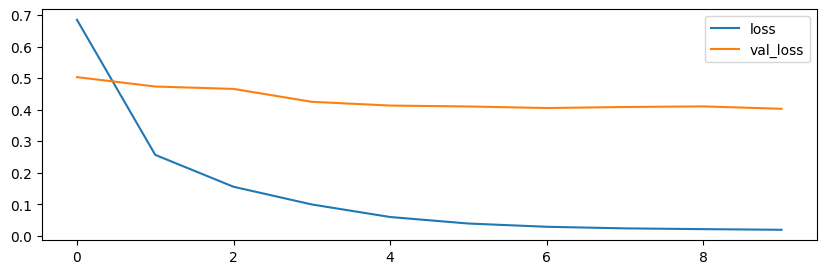

In [21]:
which_rep = 0
iteration = iterartion_list[which_rep]
report_list = report_itr_list[which_rep]
print("iteration: ", iteration)

# Create a single subplot when iteration is 1
if iteration == 1:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    ax_list = [ax]
else:
    fig, axs = plt.subplots(nrows=iteration, ncols=1, figsize=(10, iteration*3))
    ax_list = [ax for ax in axs]

for i, rep in enumerate(report_list):
    ax_list[i].plot(rep[4])
    ax_list[i].plot(rep[5])
    ax_list[i].legend(['loss', 'val_loss'])

plt.subplots_adjust(hspace=0.5)
plt.show()

## accuracy

iteration:  1
Figure(1000x300)
[<Axes: >]



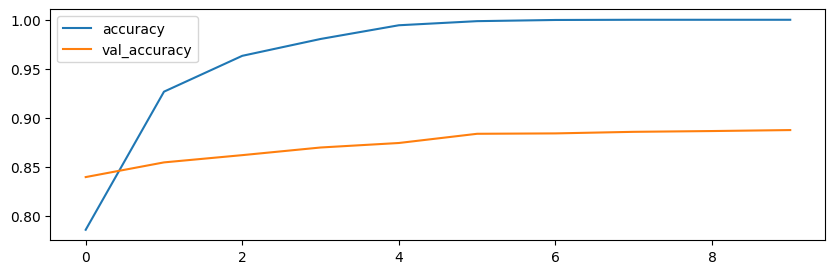

In [26]:
which_rep = 0
iteration = iterartion_list[which_rep]
report_list = report_itr_list[which_rep]
print("iteration: ", iteration)

# Create a single subplot when iteration is 1
if iteration == 1:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    ax_list = [ax]
else:
    fig, axs = plt.subplots(nrows=iteration, ncols=1, figsize=(10, iteration*3))
    ax_list = [ax for ax in axs]

for i, rep in enumerate(report_list):
    ax_list[i].plot(rep[6])
    ax_list[i].plot(rep[7])
    ax_list[i].legend(['accuracy', 'val_accuracy'])

plt.subplots_adjust(hspace=0.5)
plt.show()


## best features according to the weights

iteration:  1


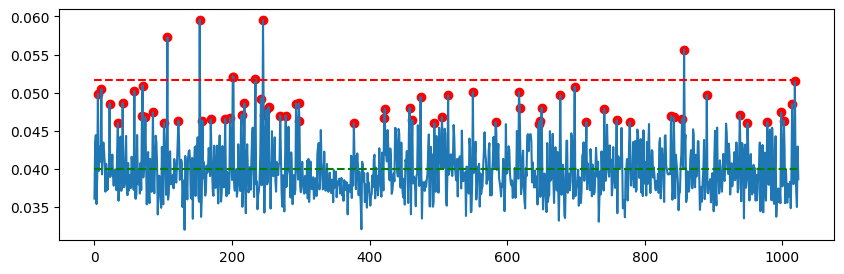

In [32]:
which_rep = 0
iteration = iterartion_list[which_rep]
report_list = report_itr_list[which_rep]
print("iteration: ", iteration)

# Create a single subplot when iteration is 1
if iteration == 1:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
    ax_list = [ax]
else:
    fig, axs = plt.subplots(nrows=iteration, ncols=1, figsize=(10, iteration*3))
    ax_list = [ax for ax in axs]

for i, rep in enumerate(report_list):
    ax_list[i].plot(rep[2])
    ax_list[i].scatter(rep[0], rep[1], color='red')
    mean =  np.mean(rep[2])
    max = np.max(rep[2])
    line = mean + (max-mean)/5*3
    ax_list[i].plot([0, rep[2].shape[0]], [line, line], color='r', linestyle='--')
    line = mean
    ax_list[i].plot([0, rep[2].shape[0]], [line, line], color='g', linestyle='--')

plt.subplots_adjust(hspace=0.5)
plt.show()

## comparing best and wors features according to overall weights

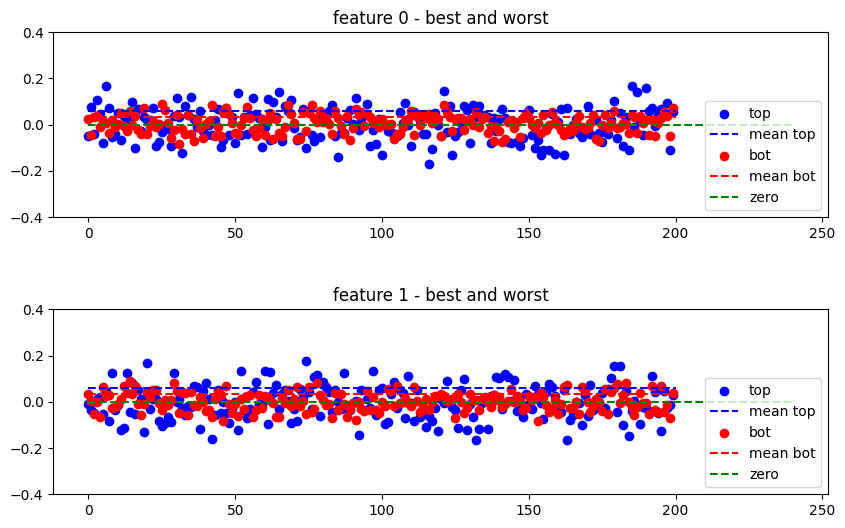

In [47]:
which_itr = 0
rep = report_list[which_itr]
weights = rep[3]
l1_norms = rep[2]
top_features_count = top_featur_count_2 = 2


sorted_indices = np.argsort(l1_norms, kind='quicksort')[::-1]
# top_features = sorted_indices[:top_featur_count]
# bot_features = sorted_indices[-top_featur_count:]

top_features = sorted_indices[:top_featur_count_2]
bot_features = sorted_indices[-top_featur_count_2:]


top_features_count = top_features.shape[0]
fig, axs = plt.subplots(nrows=top_features_count, ncols=1, figsize=(10, top_features_count*3))

ax_list = []
for i in range(top_features_count):
    ax_list.append(axs[i])

for i,t_feat in enumerate(top_features):
  ## top  ##
  var_t = np.var(np.abs(weights[t_feat]))
  sum_t = np.sum(np.abs(weights[t_feat]))
  mean = np.mean(np.abs(weights[t_feat]))
  ax_list[i].scatter(range(0,weights.shape[1]), weights[t_feat], color='b')
  ax_list[i].plot([0, weights.shape[1]], [mean, mean], color='b', linestyle='--')

  ## bot  ##
  var_b = np.var(np.abs(weights[bot_features[i]]))
  sum_b = np.sum(np.abs(weights[bot_features[i]]))
  mean = np.mean(np.abs(weights[bot_features[i]]))
  ax_list[i].scatter(range(0,weights.shape[1]), weights[bot_features[i]], color='r')
  ax_list[i].plot([0, weights.shape[1]], [mean, mean], color='r', linestyle='--')

  ax_list[i].plot([0, int(1.2*weights.shape[1])], [0, 0], color='g', linestyle='--')
  ax_list[i].set_ylim(-0.4, 0.4)
  # print('sum_a : ', sum_t, ' var_a : ', var_t, 'sum_b : ', sum_b, ' var_b : ', var_b)
  ax_list[i].legend(['top', 'mean top', 'bot', 'mean bot', 'zero'], loc='lower right')
  ax_list[i].set_title(f'feature {i} - best and worst')
plt.subplots_adjust(hspace=0.5)
plt.show()

## comparing best and wors features according to overall absolute weights in sorted view

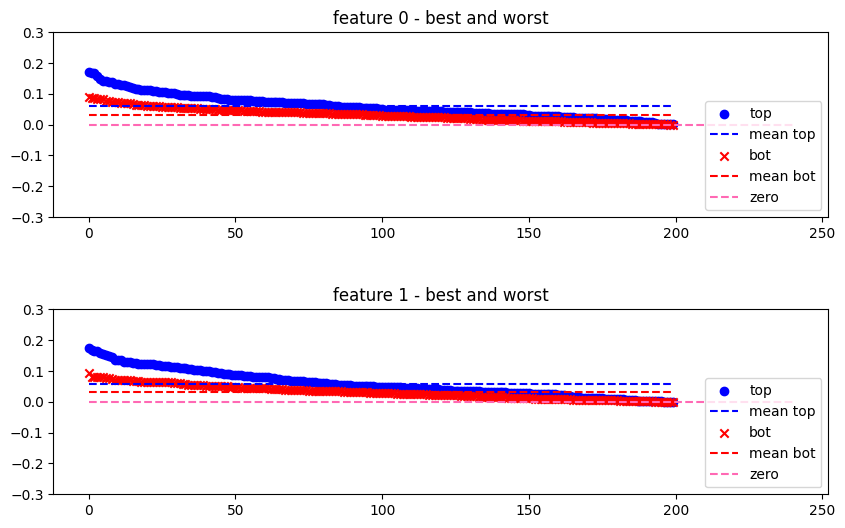

In [48]:
itr = 0
rep = report_list[itr]
weights = rep[3]
l1_norms = rep[2]
top_featur_count = 10
top_wiet_count_count = int(hidden_size)

sorted_indices = np.argsort(l1_norms, kind='quicksort')[::-1]
top_features = sorted_indices[:top_featur_count]
bot_features = sorted_indices[-top_featur_count:]

top_featur_count_2 = 2
top_features = sorted_indices[:top_featur_count_2]
bot_features = sorted_indices[-top_featur_count_2:]

top_features_count = top_features.shape[0]
fig, axs = plt.subplots(nrows=top_features_count, ncols=1, figsize=(10, top_features_count*3))


ax_list = []
for i in range(top_features_count):
    ax_list.append(axs[i])

for i,t_feat in enumerate(top_features):
  ## top  ##
  sorted_ids = np.argsort(np.abs(weights[top_features[i]]), kind='quicksort')[::-1]
  top_w = sorted_ids[:top_wiet_count_count]
  weights_t_feat = (weights[top_features[i]])[top_w]
  mean = np.mean(np.abs(weights_t_feat))
  ax_list[i].scatter(range(0,weights_t_feat.shape[0]), np.abs(weights_t_feat), color='b')
  ax_list[i].plot([0, (weights_t_feat.shape[0]-1)], [mean, mean], color='b', linestyle='--')

  ## bot  ##
  sorted_ids = np.argsort(np.abs(weights[bot_features[i]]), kind='quicksort')[::-1]
  bot_w = sorted_ids[:top_wiet_count_count]
  weights_b_feat = (weights[bot_features[i]])[bot_w]
  mean = np.mean(np.abs(weights_b_feat))
  ax_list[i].scatter(range(0,weights_b_feat.shape[0]), np.abs(weights_b_feat), color='r', marker="x")
  ax_list[i].plot([0, (weights_b_feat.shape[0]-1)], [mean, mean], color='r', linestyle='--', label = "mean bot")

  ax_list[i].plot([0, int(1.2*(weights_b_feat.shape[0]))], [0, 0], color='hotpink', linestyle='--')
  ax_list[i].set_ylim(-0.3, 0.3)
  ax_list[i].legend(['top', 'mean top', 'bot', 'mean bot', 'zero'], loc='lower right')
  ax_list[i].set_title(f'feature {i} - best and worst')

plt.subplots_adjust(hspace=0.5)
plt.show()